<h1><center>Google Analytics Customer Revenue Prediction</center></h1>

***

# Business problem:

### Description:
Source: https://www.kaggle.com/c/ga-customer-revenue-prediction
<br>
##### Problem statement  :
 - In every business it was proven about 80-20 rule., this rule tells us 80%  of our revenue will be generated by only 20% of our potential customers. So our goal is to predict the revenue that is going to be generated by those potential customers in the near feature. So that marketing teams will invest appropriate money on promotional strategies to attract potential customers.
 - In simple words we are given with the users past data and transactions  (when they logged into Gstore)., so by using this data we need to predict the future revenue will be created by those customers.
 - So google provided Merchandise customer dataset and no.of transactions per customer. We will build a predictive model using Gstore data set to predict the total revenue per customer that helps in better use of marketing budget and we will also interpret the most impacting element on the total revenue prediction using different models.
<br>

### Business objectives and constraints:
 - No latency requirements.
 - Provide actionable insights for better use of marketing budgets.

***

## Machine Learning formulation of business problem

### Data:

### Data Overview:
 - source: https://www.kaggle.com/c/ga-customer-revenue-prediction/data
 - we need to download train_v2.csv and test_v2.csv
 - we will be predicting the target for all users in the posted test set: test_v2.csv, for their transactions in the future time period of December 1st 2018 through January 31st 2019.
 - Each row in the dataset is one visit to the store. Because we are predicting the log of the total revenue per user, not all rows in test.csv will correspond to a row in the submission, but all unique fullVisitorIds will correspond to a row in the submission.
 - some of the features are in json format so we need to parse those json columns., regarding this we will see in brief at the time of data reading
 
<br>

#### Data fields:

 - fullVisitorId- A unique identifier for each user of the Google Merchandise Store.

 - channelGrouping - The channel via which the user came to the Store.

 - date - The date on which the user visited the Store.

 - device - The specifications for the device used to access the Store.

 - geoNetwork - This section contains information about the geography of the user.

 - sessionId - A unique identifier for this visit to the store.

 - socialEngagementType - Engagement type, either “Socially Engaged” or “Not Socially Engaged”.

 - totals - This section contains aggregate values across the session.

 - trafficSource - This section contains information about the Traffic Source from which the session originated.

 - visitId - An identifier for this session. This is part of the value usually stored as the utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

 - visitNumber - The session number for this user. If this is the first session, then this is set to 1.

 - visitStartTime - The timestamp (expressed as POSIX time).
 
* Feature desciptions:
 - https://support.google.com/analytics/answer/3437719?hl=en
 

## Mapping the real-world problem to an ML problem:

### Type of Machine Learning Problem:
 - So here we are going to predict the revenue generated by the customer (in dollars) when they visits the store, so we can pose this problem as regression problem.

### Performance Metric:
 - We are predicting the natural log of the sum of all transactions per user.
 - So a good metirc for regresion problems would be RMSE.
 <br>
 $\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$ ,
 <br>
 - where y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.

## Train and Test Datasets:

 - train data : transactions from Aug 1st 2016 to April 30th 2018
 - test  data : transactions from May 1st 2018 to Octob 15th 2018
 - kaggle private leader board prediction data : Dec 1st 2018 to jan 31 st 2019

***

In [1]:
# importing the modules 
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from time import time
import pickle
from tqdm import tqdm
from IPython.display import display 
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
import datetime as dt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor

In [48]:
# credits : https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
def load_df(csv_path, nrows=None):
    # define a list of JSON columns to decode
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={
                         # converting dtype from string to json
                         column: json.loads for column in JSON_COLUMNS}, 
                     # treating 'fullVisitorId' as string
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)

    for column in JSON_COLUMNS:
        # json_normalize will return flattened normalized semi-structured JSON data
        column_as_df = json_normalize(df[column])
        # extracting column names in "column.subcolumn" format, eg. "totals.hits"
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns] 
        # drop original encoded json columns and merge new json parsed columns
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) 
        
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    
    return df

In [49]:
%%time
# train_df = load_df('../train_v2.csv')
test_df = load_df('/demo-mount/test_v2.csv')

Loaded test_v2.csv. Shape: (401589, 59)
CPU times: user 2min 17s, sys: 18.9 s, total: 2min 36s
Wall time: 2min 36s


## Saving loaded dataframes in a pickle file

In [28]:
with open('../test_v2.pickle','wb') as f:
    pickle.dump(test_df, f)
    
with open('../train_v2.pickle','wb') as f:
    pickle.dump(train_df, f)

## Load dataframes from pickle files

In [2]:
start = time()
with open('../train_v2.pickle','rb') as f:
    train_df = pickle.load(f)

with open('../test_v2.pickle','rb') as f:
    test_df = pickle.load(f)
end = time()
print(f'Time for loading pickle files: {(end-start)/60} mins')

Time for loading pickle files: 6.244447934627533 mins


In [8]:
# checking loaded pickle files
print(f'train shape: {train_df.shape} \ntest shape: {test_df.shape}')

train shape: (1708337, 60) 
test shape: (401589, 59)


In [5]:
# checking loaded pickle files
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# checking loaded pickle files
test_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,1526067157,2,1526067157,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",Not Socially Engaged,1526107551,4,1526107551,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1526060254,1,1526060254,Internet Explorer,...,organic,(not provided),(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


* creating a smaller df to test code faster because original train df is very large in size

In [9]:
train_subset = train_df[:10000].copy(deep=True)
train_subset.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

### Remove columns having single values throughout as they are not useful for predicting the target variable.

In [5]:
# nunique() gives the count of unqiues values of each column
train_subset.nunique()

channelGrouping                                         7
customDimensions                                        6
date                                                    4
fullVisitorId                                        9210
hits                                                 9809
socialEngagementType                                    1
visitId                                              9812
visitNumber                                            73
visitStartTime                                       9813
device.browser                                         23
device.browserVersion                                   1
device.browserSize                                      1
device.operatingSystem                                 15
device.operatingSystemVersion                           1
device.isMobile                                         2
device.mobileDeviceBranding                             1
device.mobileDeviceModel                                1
device.mobileI

In [3]:
start = time()
# make a list of all column names
column_list = train_df.columns.to_list()
for column in column_list:
    # dropping columns having single value across all rows
    if train_df[column].nunique() == 1:
        del train_df[column]

end = time()

print(f'Time taken: {(end-start)/60} mins')
print(f'After dropping single valued columns df size is: {train_df.shape}')
train_df.head(2)

Time taken: 1.3655794382095336 mins
After dropping single valued columns df size is: (1708337, 36)


,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN


In [4]:
%%time
train_df.nunique()

CPU times: user 1min 45s, sys: 96.8 ms, total: 1min 45s
Wall time: 1min 45s


channelGrouping                                       8
customDimensions                                      6
date                                                638
fullVisitorId                                   1323730
hits                                            1338924
visitId                                         1665802
visitNumber                                         457
visitStartTime                                  1667423
device.browser                                      129
device.operatingSystem                               24
device.isMobile                                       2
device.deviceCategory                                 3
geoNetwork.continent                                  6
geoNetwork.subContinent                              23
geoNetwork.country                                  228
geoNetwork.region                                   483
geoNetwork.metro                                    123
geoNetwork.city                                 

In [5]:
# SAVING RAW DATA FOR EDA
with open('../train_eda.pickle', 'wb') as f:
    pickle.dump(train_df, f)

# Feature Importance

* **We will train a Random Forest regressor for calculating the feature importances.**

In [61]:
train_df.dtypes

channelGrouping                                 object
customDimensions                                object
date                                             int64
fullVisitorId                                   object
hits                                            object
visitId                                          int64
visitNumber                                      int64
visitStartTime                                   int64
device.browser                                  object
device.operatingSystem                          object
device.isMobile                                   bool
device.deviceCategory                           object
geoNetwork.continent                            object
geoNetwork.subContinent                         object
geoNetwork.country                              object
geoNetwork.region                               object
geoNetwork.metro                                object
geoNetwork.city                                 object
geoNetwork

In [63]:
numeric_feat = ['visitNumber','visitStartTime','totals.hits','totals.pageviews','totals.timeOnSite',
                'totals.transactions','totals.totalTransactionRevenue','totals.transactionRevenue']
# filling 0 inplace of NaN for our model
for col in numeric_feat:
    train_df[col].fillna(0,inplace=True)  

In [64]:
# drop useless features
train_df.drop(['customDimensions', 'hits'], axis=1, inplace=True)

In [66]:
%%time
# list of categorical columns
object_cols = list(train_df.select_dtypes(include=['object', 'bool']).columns)
# source : https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
for feature in object_cols:
    # intitalizing label encoder object
    label_encoder = preprocessing.LabelEncoder()
    # fit with list of variables in that feature
    label_encoder.fit(list(train_df[feature].values.astype('str')))
    # transforming that feature
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str')))
    print(f"Label encoding for {feature} completed.")

Label encoding for channelGrouping completed.
Label encoding for fullVisitorId completed.
Label encoding for device.browser completed.
Label encoding for device.operatingSystem completed.
Label encoding for device.isMobile completed.
Label encoding for device.deviceCategory completed.
Label encoding for geoNetwork.continent completed.
Label encoding for geoNetwork.subContinent completed.
Label encoding for geoNetwork.country completed.
Label encoding for geoNetwork.region completed.
Label encoding for geoNetwork.metro completed.
Label encoding for geoNetwork.city completed.
Label encoding for geoNetwork.networkDomain completed.
Label encoding for totals.sessionQualityDim completed.
Label encoding for totals.timeOnSite completed.
Label encoding for totals.transactions completed.
Label encoding for totals.transactionRevenue completed.
Label encoding for totals.totalTransactionRevenue completed.
Label encoding for trafficSource.campaign completed.
Label encoding for trafficSource.source c

In [73]:
# split train and target variables
target = train_df['totals.transactionRevenue']
# drop target column
train = train_df.drop(['totals.transactions','totals.transactionRevenue','totals.totalTransactionRevenue'], axis=1)
train['date']=train['date'].map(dt.datetime.toordinal)

In [11]:
# Defining parameters for our RandomForestRegressor model
rfr = RandomForestRegressor(bootstrap=True, criterion='mse',
       max_features='auto',n_estimators=500, n_jobs=-1,random_state=44, verbose=1)

# Train the regressor model
rfr.fit(train, target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.2min finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=44, verbose=1)

In [87]:
# SAVING FILES AS PICKLE
with open('../rfr.pickle', 'wb') as f:
    pickle.dump(rfr, f)
with open('../train_feature_importance.pickle', 'wb') as f:
    pickle.dump(train, f)
with open('../target_feature_importance.pickle', 'wb') as f:
    pickle.dump(target, f)

In [19]:
# READ PICKLE FILES
with open('../rfr.pickle', 'rb') as f:
    rfr = pickle.load(f)
with open('../train_feature_importance.pickle', 'rb') as f:
    train = pickle.load(f)    
with open('../target_feature_importance.pickle', 'rb') as f:
    target = pickle.load(f)

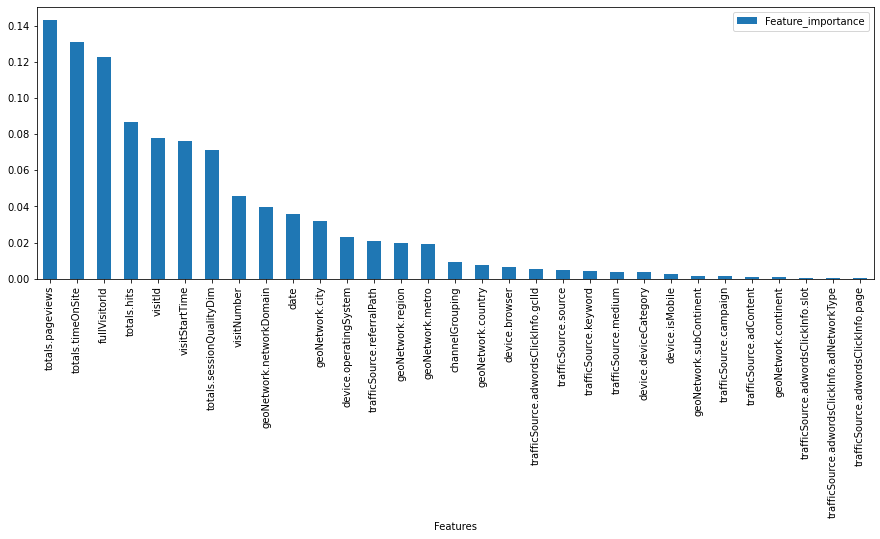

In [70]:
# importance of each attribute
feature_imp_df = pd.DataFrame({'Features':train.columns.values, 'Feature_importance':rfr.feature_importances_})
feature_imp_df.sort_values(by=['Feature_importance'], ascending = False).plot(kind='bar', x='Features', y='Feature_importance', figsize=(15,5));

* **Observations:-**
    1. Pageviews and timeOnSite are 2 most important features according to the Random Forest model.
    2. We will not consider VisitorId and visitId even though the model gives it high importance because individually they will not help to generalise the model.
    3. We will mainly focus on top 10-15 features for the EDA.

# EDA
References used:
* https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
* https://www.kaggle.com/kabure/exploring-the-consumer-patterns-ml-pipeline

* **READING RAW DATA FOR EDA**

In [2]:
%%time
with open('../train_eda.pickle','rb') as f:
    train_df = pickle.load(f)

CPU times: user 19.2 s, sys: 22.9 s, total: 42.1 s
Wall time: 3min 42s


In [11]:
# global plotting configurations
params = {'axes.titlesize':'32',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20'}
matplotlib.rcParams.update(params)

## Univariate Analysis

### Target variable

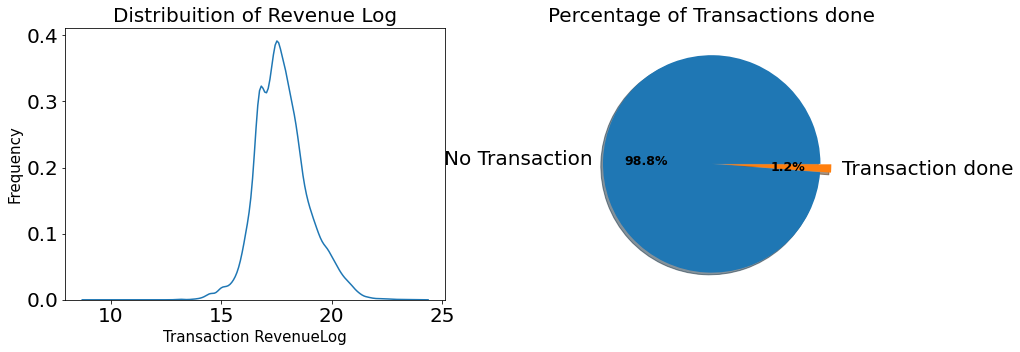

In [5]:
# converting to type 'float'
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

# seting the figure size of our plots
fig = plt.figure(figsize=(15,5))
# creating a subplot grid of 1 x 2
plt.subplot(1,2,1)
# plotting log distribution of transactionRevenue
ax = sns.kdeplot(np.log1p(train_df["totals.transactionRevenue"]))
#seting the xlabel and size of font
ax.set_xlabel('Transaction RevenueLog', fontsize=15)
# seting the ylabel and size of font
ax.set_ylabel('Frequency', fontsize=15)
# seting the title and size of font
ax.set_title("Distribuition of Revenue Log", fontsize=20)

# setting the second plot of our grid
plt.subplot(1,2,2)
# grouping by transactionRevenue according to each customer
tmp = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
# setting all customers having transactionRevenue > 0 to 1
tmp.loc[tmp['totals.transactionRevenue']>0] = 1
# custom labels:- 0:No Transaction  1:Transaction done
mylabels = ['No Transaction', 'Transaction done']
# credits: https://stackoverflow.com/questions/57062322/python-how-to-change-autopct-text-to-white-and-bold-in-a-pie-chart
_, _, autopcts = plt.pie(tmp['totals.transactionRevenue'].value_counts(), explode=[0,0.1], labels=mylabels, autopct='%1.1f%%',
        shadow=True)
plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':12.5})
#seting the title and size of font
plt.title("Percentage of Transactions done", fontsize=20)

plt.show()

* **Observations:**
    1. We can see that the natural log of target variable(TransactionRevenue) follows gaussian distribution, which is good because we don't need to deal with unbalanced-target-problem.
    2. From the pie chart we can see that from all our customers only **1.2% have completed a transaction.**

### Date plots

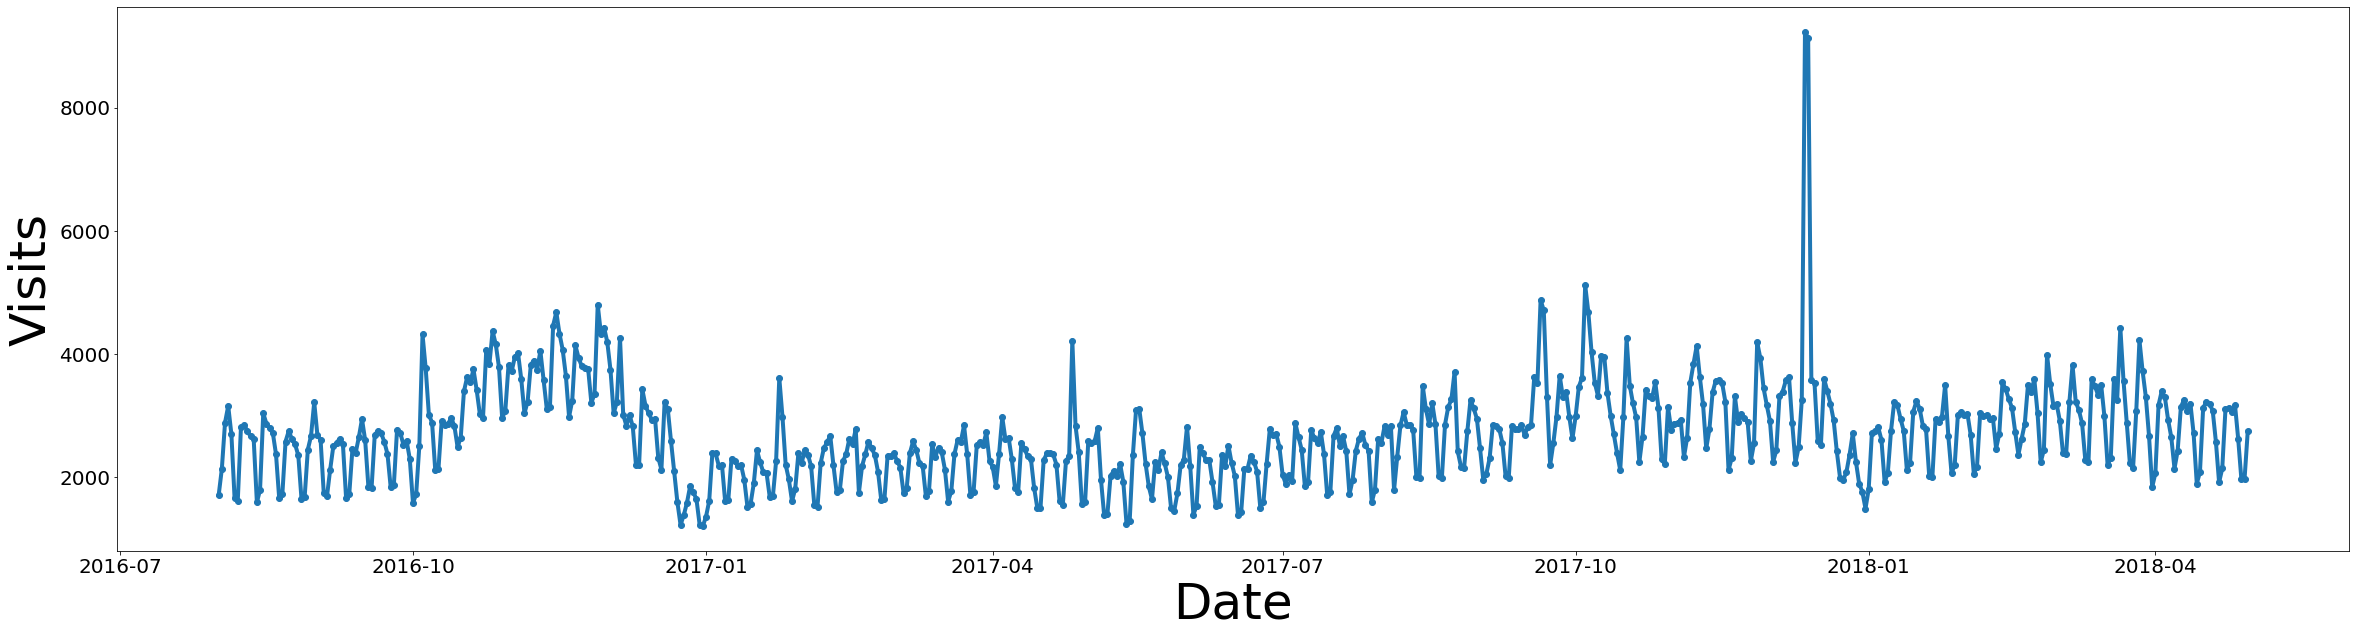

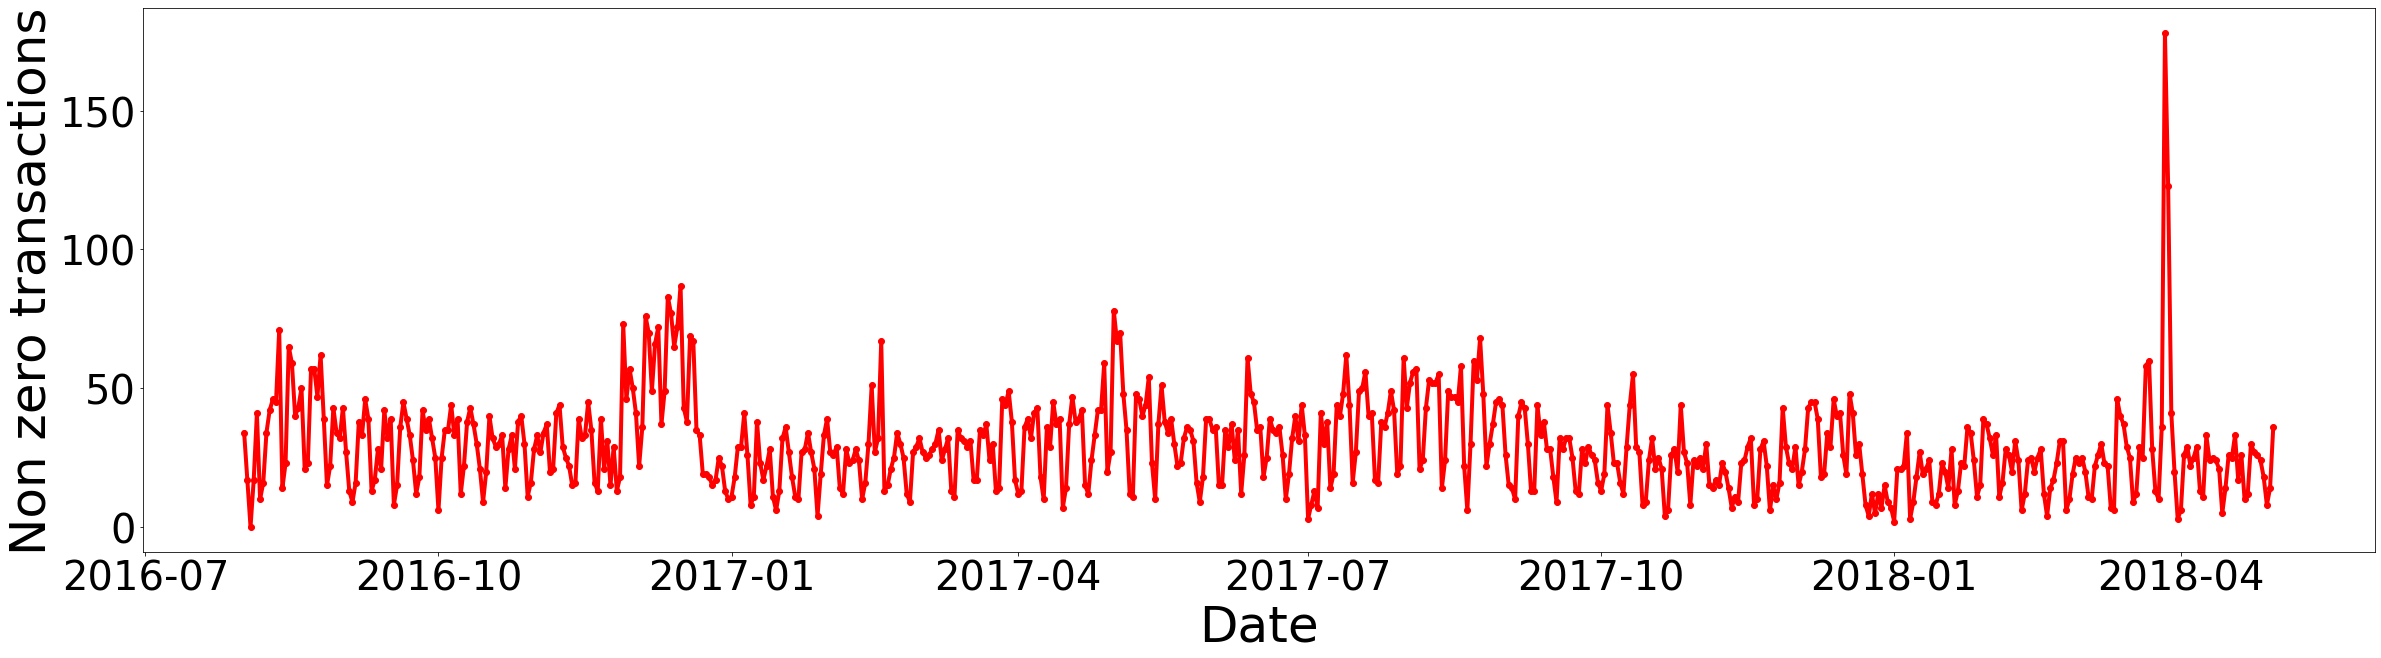

In [5]:
# converting to datetime format
train_df["date"] = pd.to_datetime(train_df["date"], format="%Y%m%d")
# groupby using .agg(['size', 'count']) where size includes NaN values, count does not.
tmp = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count']).reset_index()
# adding column names
tmp.columns = ["date", "count", "count of non-zero revenue"]

# plot for no.of visits in each date :
plt.figure(figsize=(40,10))
plt.plot_date(x = tmp['date'], y = tmp['count'],linestyle='solid',linewidth=4)
# set labels and labelsize for x,y axes
plt.xlabel('Date',fontsize=50)
plt.ylabel('Visits',fontsize=50)
# set size of ticks on x,y axes
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40) 

# plot for transcation revenue in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = tmp['date'], y = tmp['count of non-zero revenue'],linestyle='solid',color='red', linewidth=4)
# set labels and labelsize for x,y axes
plt.xlabel('Date',fontsize=50)
plt.ylabel('Non zero transactions',fontsize=50)
# set size of ticks on x,y axes
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)

plt.show()

* **Observations:**
    1. No of visits increased in Dec 2017 drastically, but no of transactions didn't.
    2. No of transactions suddenly incresed in March 2018

### Pageviews

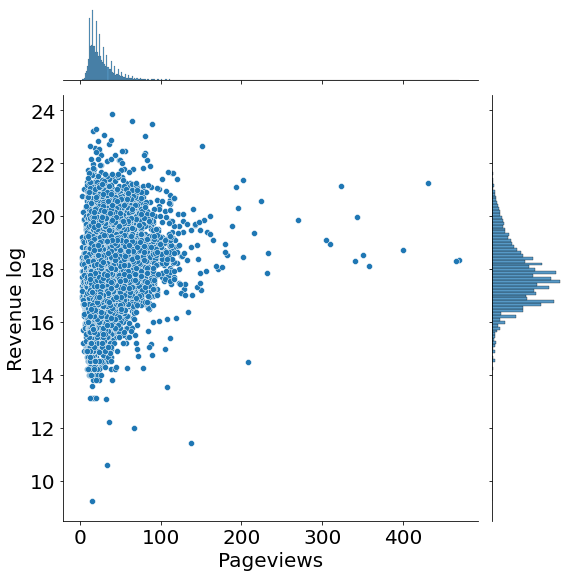

In [34]:
# changing datatype of pageviews to float32
train_df['totals.pageviews'] = train_df['totals.pageviews'].astype('float32')
# adding new column by taking log of transactionRevenue
train_df['revenue_log'] = np.log1p(train_df['totals.transactionRevenue'])
# joint-plot
jplot = sns.jointplot(x='totals.pageviews', y='revenue_log', data=train_df, height=8, dropna=True)
jplot.set_axis_labels('Pageviews', 'Revenue log', fontsize=20)
plt.show()

In [36]:
train_df['totals.pageviews'].describe()

count    1.708098e+06
mean     3.696202e+00
std      6.491154e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      5.000000e+02
Name: totals.pageviews, dtype: float64

* **Observations:**
    1. Around 75% of pageviews lies between 1-4.
    2. Log of transactionRevenue follows a normal distribution against pageviews but there is no direct correlation between them.

### TimeOnSite

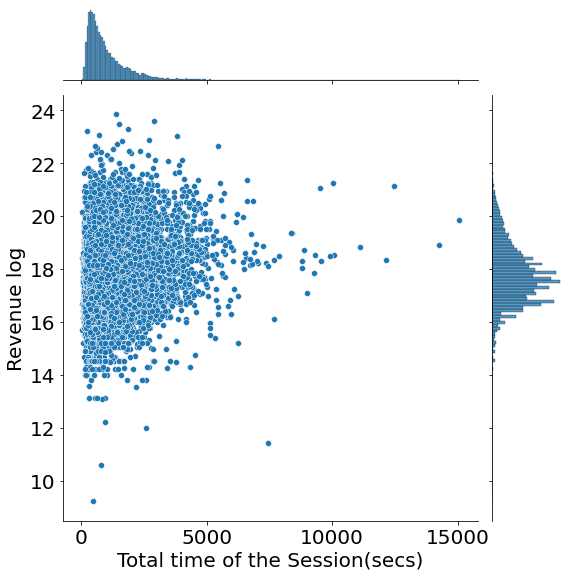

In [35]:
train_df['totals.timeOnSite'] = train_df['totals.timeOnSite'].astype('float32')
jplot = sns.jointplot(x='totals.timeOnSite', y='revenue_log', data=train_df, height=8, dropna=True)
jplot.set_axis_labels('Total time of the Session(secs)', 'Revenue log', fontsize=20)
plt.show()

In [38]:
train_df['totals.timeOnSite'].describe()

count    834043.000000
mean        253.648499
std         473.665497
min           1.000000
25%          31.000000
50%          80.000000
75%         244.000000
max       19017.000000
Name: totals.timeOnSite, dtype: float64

* **Observations:**
    1. Around 75% users spend less than 4 mins(244 secs) on a session.
    2. Log of transactionRevenue follows a normal distribution against timeOnSite but there is no direct correlation between them.

### Hits

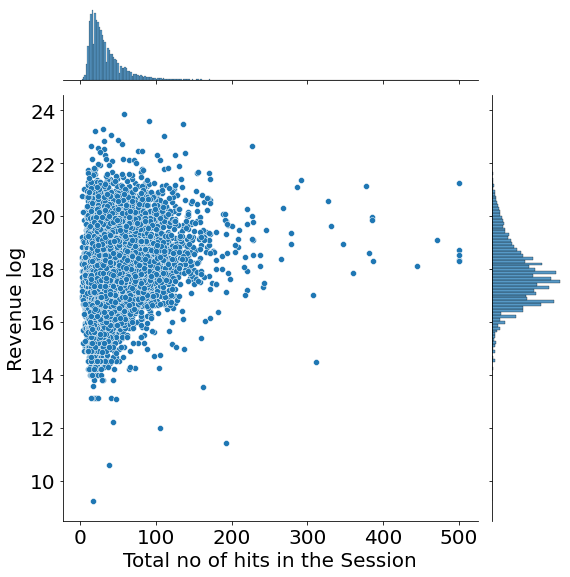

In [42]:
train_df['totals.hits'] = train_df['totals.hits'].astype('float32')
jplot = sns.jointplot(x='totals.hits', y='revenue_log', data=train_df, height=8, dropna=True)
jplot.set_axis_labels('Total no of hits in the Session', 'Revenue log', fontsize=20)
plt.show()

In [43]:
train_df['totals.hits'].describe()

count    1.708337e+06
mean     4.429598e+00
std      8.946826e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      5.000000e+02
Name: totals.hits, dtype: float64

In [44]:
# correltaion between hits and pageviews
train_df['totals.hits'].corr(train_df['totals.pageviews'])

0.9797984001757967

* **Observations:**
    1. Around 75% of hits in a session lies between 1-4.
    2. Log of transactionRevenue follows a normal distribution against hits but there is no direct correlation between them.
    3. Hits and Pageviews are highly corelated (Pearson corelation = 0.98)

## Channel Grouping analysis

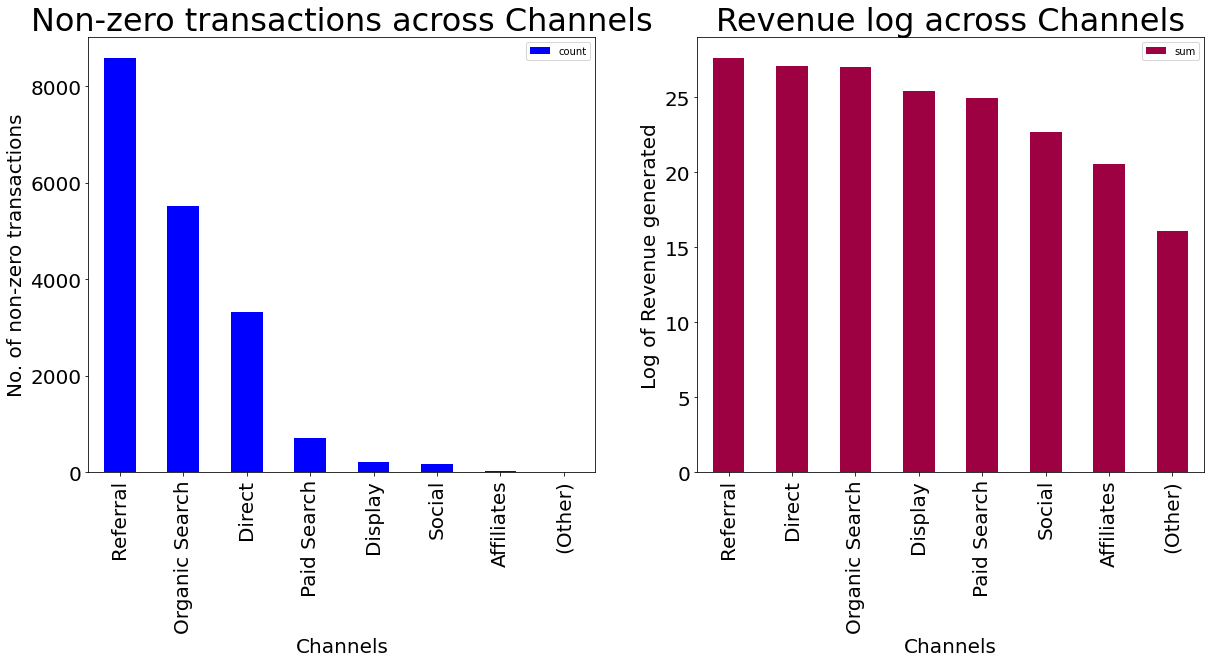

In [8]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of transactions across each channel------
# grouping by channels according to each customer
tmp = train_df.groupby('channelGrouping')['totals.transactionRevenue'].agg(['count','sum']).reset_index()
# plotting the bar graph
tmp.sort_values('count', ascending=False).plot(kind='bar', x='channelGrouping', y='count', \
                                               colormap='winter', ax=axes[0], \
                                               title = 'Non-zero transactions across Channels')
# setting labels for x,y axes
axes[0].set_xlabel("Channels", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------log of revenue generated by each channel-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
tmp.sort_values('sum', ascending=False).plot(kind='bar', x='channelGrouping', y='sum', \
                                             title="Revenue log across Channels", colormap='Spectral', ax=axes[1])
# setting labels for x,y axes
axes[1].set_xlabel("Channels", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

# display plots
plt.show()

* **Observations:**
    1. Most transactions come from Referral and Organic search; they also have high revenue generation.
    2. No of transactions from Direct sources are low but their revenue generation is high, on par with Referral and Organic search.

## Web browser analysis 

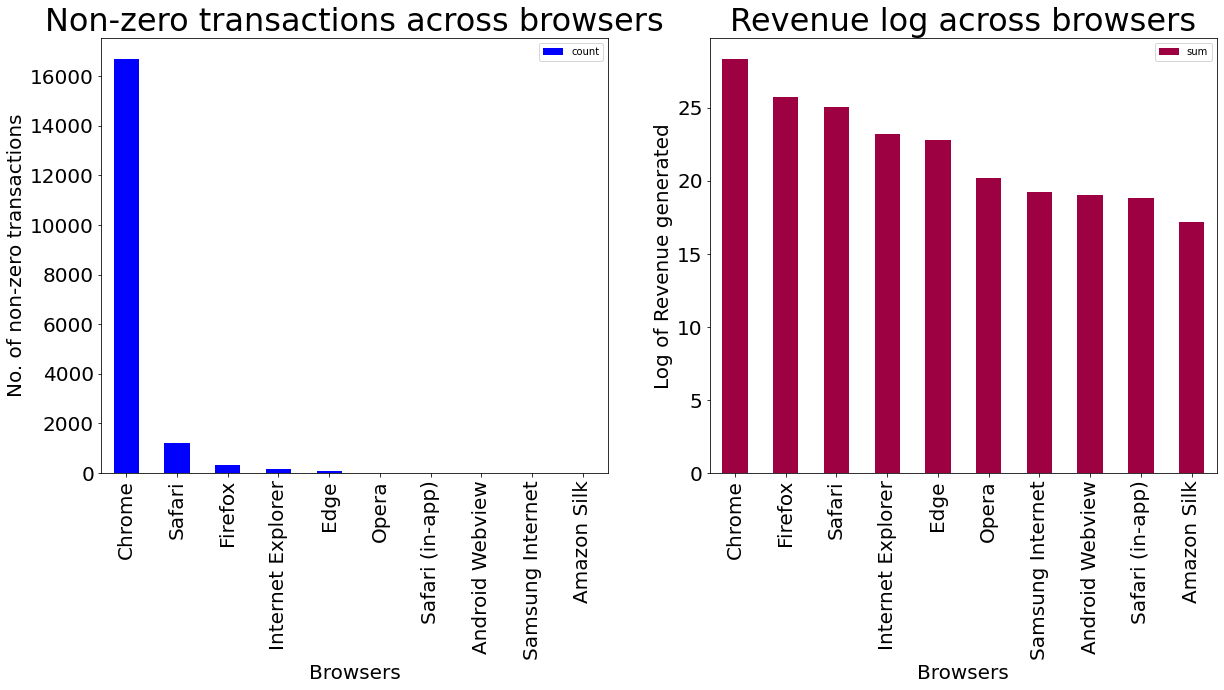

In [11]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of transactions across each browser------
# grouping by browsers according to each customer
tmp = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['count','sum']).reset_index()
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('count', ascending=False).head(10).plot(kind='bar', x='device.browser', y='count', \
                                                        colormap='winter', ax=axes[0], \
                                                        title = 'Non-zero transactions across browsers')
axes[0].set_xlabel("Browsers", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------log of revenue generated by each browser-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('sum', ascending=False).head(10).plot(kind='bar', x='device.browser', y='sum', \
                                                       title="Revenue log across browsers", 
                                                       colormap='Spectral', ax=axes[1])
axes[1].set_xlabel("Browsers", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

plt.show()

* **Observations:**
    1. No of transactions and revenue generated is highest from Chrome.
    2. Firefox and Safari users have very low transactions compared to Chrome but their revenue generation is close to that of Chrome. 
    3. Marketing teams can focus on chrome users to maximise the revenue generation.

## City analysis

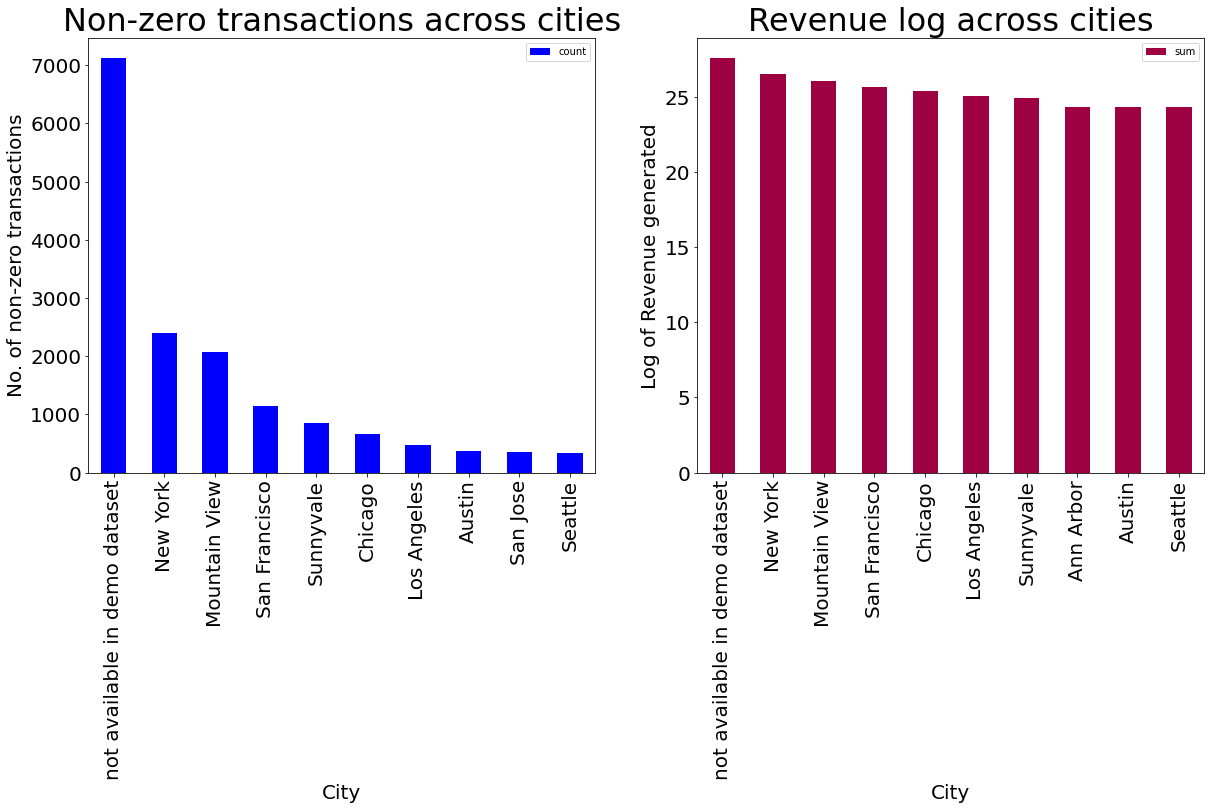

In [17]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of transactions across each city------
# grouping by city according to each customer
tmp = train_df.groupby('geoNetwork.city')['totals.transactionRevenue'].agg(['sum', 'count']).reset_index()
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('count', ascending=False).head(10).plot(kind='bar', x='geoNetwork.city', \
                                                        y='count', colormap='winter', ax=axes[0], \
                                                        title = 'Non-zero transactions across cities')
axes[0].set_xlabel("City", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------revenue generated by each city-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('sum', ascending=False).head(10).plot(kind='bar', x='geoNetwork.city', y='sum', \
                                                      title="Revenue log across cities", \
                                                      colormap='Spectral', ax=axes[1])
axes[1].set_xlabel("City", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

plt.show()

In [53]:
print('Count of cities:-')
val_cnt = train_df['geoNetwork.city'].value_counts()
print(val_cnt)
# adding not avaiable rows for city
missing_city = val_cnt[0] + val_cnt[2]
print('='*50)
print(f'{(missing_city/len(train_df)*100)}% of city data is missing.')

Count of cities:-
not available in demo dataset    932959
Mountain View                     74110
(not set)                         65867
New York                          49460
San Francisco                     36960
                                  ...  
Morgan Hill                           4
North Creek                           4
Daly City                             4
Chandler                              3
Boise                                 3
Name: geoNetwork.city, Length: 956, dtype: int64
58.46773792290397% of city data is missing.


* **Observations:**
    1. Lot of city data is missing in the dataset (58%).
    2. New York, Mountain View and San Francisco are 3 most high revenue generating cities with most number of transactions.

# Multivariate analysis

### Grouping OS and browsers to see their impact on transactionRevenue

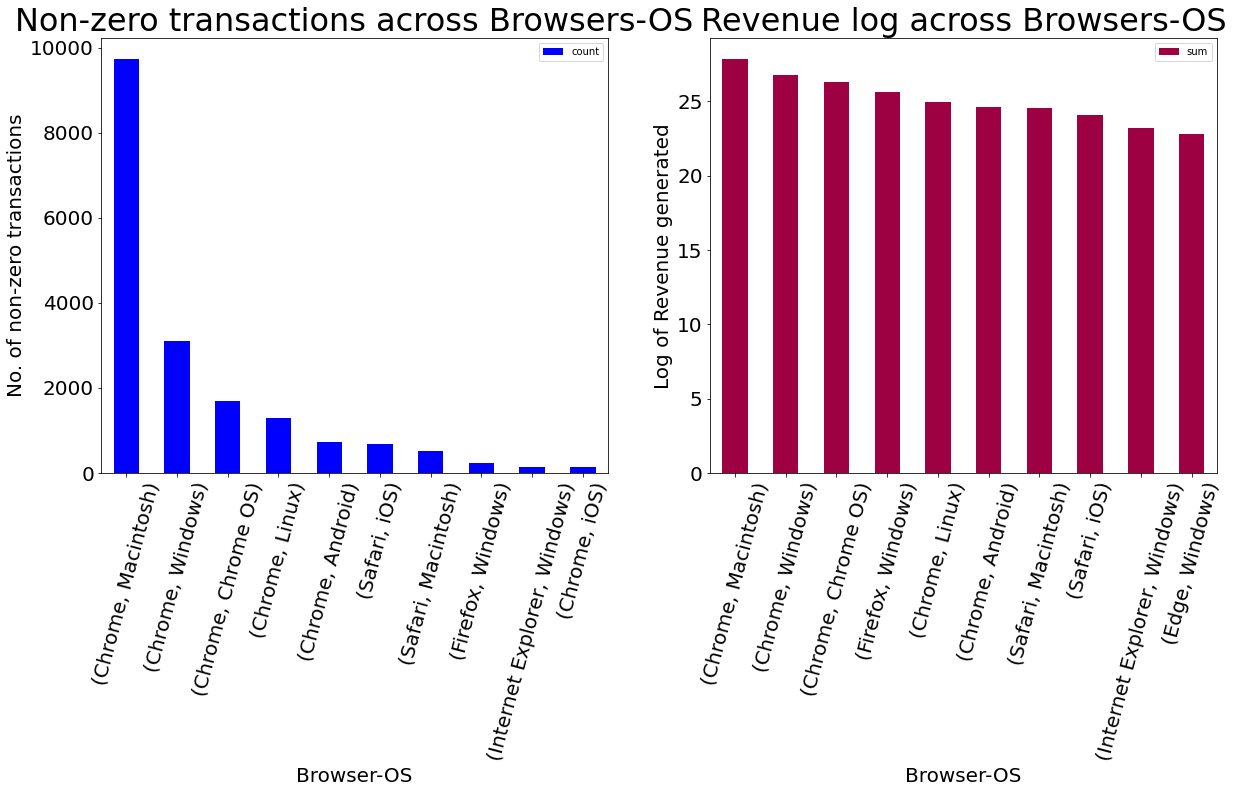

In [12]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of transactions across Browser-OS groups------
# grouping by Browser-OS
tmp = train_df.groupby(['device.browser', 'device.operatingSystem'])['totals.transactionRevenue'].agg(['sum', 'count']).sort_values('sum', ascending=False)
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('count', ascending=False).head(10).plot(kind='bar',  \
                                                        y='count', colormap='winter', ax=axes[0], \
                                                        title = 'Non-zero transactions across Browsers-OS', rot=75)
axes[0].set_xlabel("Browser-OS", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------revenue generated across Browser-OS-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('sum', ascending=False).head(10).plot(kind='bar',  y='sum', \
                                                      title="Revenue log across Browsers-OS", \
                                                      colormap='Spectral', ax=axes[1], rot=75)
axes[1].set_xlabel("Browser-OS", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

plt.show()

* **Observations:**
    1. Both Windows and Mac users have higher transactions and total revenue generation using the Chrome browser.
    2. Across all Operating systems chrome users have higher number of transactions.
    3. This supports earlier conclusion that chrome users generates more revenue compared to other browser users.

# Data Imputation

In [3]:
def missing_values(dataframe):
    ''' Calculates the no of missing values and their percentage for each column of the given dataframe and 
    displays it in a dataframe format.'''
    
    # isnull() : finding the missing values 
    # sum()    : taking the sum across all rows 
    # sort_values(ascending = False) : sorting in descending order
    total = dataframe.isnull().sum().sort_values(ascending = False) # total is the number of rows missing
    
    # percentage of missing values
    missing_values_series = total / len(dataframe) * 100
    # creating a dataframe to save this information
    missing_values_df = pd.concat([total, missing_values_series], axis=1, keys=['no of rows missing', 'percentage of data missing'])
    # display only columns having the missing values
    display(missing_values_df[missing_values_df['no of rows missing']!=0])
    

In [91]:
%%time
# dropping revenue_log column that was added only of EDA
train_df.drop('revenue_log', axis=1, inplace=True)
missing_values(train_df)

,no of rows missing,percentage of data missing
totals.transactionRevenue,1689823,98.916256
totals.totalTransactionRevenue,1689823,98.916256
totals.transactions,1689778,98.913622
trafficSource.adContent,1643600,96.210525
trafficSource.adwordsClickInfo.adNetworkType,1633063,95.593727
trafficSource.adwordsClickInfo.slot,1633063,95.593727
trafficSource.adwordsClickInfo.page,1633063,95.593727
trafficSource.adwordsClickInfo.gclId,1632914,95.585005
trafficSource.referralPath,1142073,66.852910
trafficSource.keyword,1052780,61.626014


CPU times: user 4.05 s, sys: 329 ms, total: 4.38 s
Wall time: 4.35 s


### Imputing the missing values 

* **totals.transactionRevenue:** Revenue generated in a session

In [92]:
%%time
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.transactionRevenue'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.transactionRevenue'].fillna(0, inplace=True)
test_df['totals.transactionRevenue'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.transactionRevenue'].isnull().sum()}")

Count of nan values:-
Before Imputation:1689823
After Imputation:0
CPU times: user 30.9 ms, sys: 819 µs, total: 31.7 ms
Wall time: 30 ms


*  **totals.totalTransactionRevenue:** Total revenue generated in a session

In [93]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.totalTransactionRevenue'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.totalTransactionRevenue'].fillna(0, inplace=True)
test_df['totals.totalTransactionRevenue'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.totalTransactionRevenue'].isnull().sum()}")

Count of nan values:-
Before Imputation:1689823
After Imputation:0


***
### Note:-
1. There seems to be some confusion regarding 'totals.totalTransactionRevenue' and 'totals.transactionRevenue' columns(source: https://www.kaggle.com/c/ga-customer-revenue-prediction/data).
2. The final conclusion from kaggle was that the target variable will be 'totals.transactionRevenue'.
***

* **totals.transactions:** No of transactions in a session

In [94]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.transactions'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.transactions'].fillna(0, inplace=True)
test_df['totals.transactions'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.transactions'].isnull().sum()}")

Count of nan values:-
Before Imputation:1689778
After Imputation:0


* **trafficSource.adContent:** The ad content of the traffic source.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [182]:
train_df['trafficSource.adContent'].unique()

array([nan, 'Placement Accessories 300 x 250', 'Google Merchandise Store',
       'Bags 300x250', 'Display Ad created 3/11/14',
       'Placement Office 300x250', 'Placement Drinkware 300x250',
       'Office Placement 160x600', 'Bags 336x280',
       'test_tyler_hr_merchant', 'Drinkware 336x280',
       'Official Google Merchandise', 'First Full Auto Template Test Ad',
       'Full auto ad IMAGE ONLY', '{KeyWord:Google Brand Items}',
       'Ad from 11/7/16', 'Display Ad created 3/11/15', 'Ad from 11/3/16',
       'Ad from 12/13/16', 'Google Online Store',
       'Google Merchandise Collection', 'Display Ad created 11/17/14',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Merchandise}',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Smart display ad - 8/17/2017',
       'BQ', 'Placement Accessores 300 x 250',
       'Placement Accessories 336 x 280',
       'Placeme

* **trafficSource.adwordsClickInfo.adNetworkType:** Network Type of the traffic source.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [183]:
train_df['trafficSource.adwordsClickInfo.adNetworkType'].unique()

array([nan, 'Google Search', 'Content', 'Search partners'], dtype=object)

* **trafficSource.adwordsClickInfo.slot:** Position of the Ad.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [184]:
train_df['trafficSource.adwordsClickInfo.slot'].unique()

array([nan, 'Top', 'RHS', 'Google Display Network'], dtype=object)

* **trafficSource.adwordsClickInfo.page:** Page number in search results where the ad was shown.
    * 95% data is missing so we will drop this column.

In [185]:
train_df['trafficSource.adwordsClickInfo.page'].unique()

array([nan, '1', '3', '2', '5', '6', '4', '14', '7', '8', '9', '12'],
      dtype=object)

* **trafficSource.adwordsClickInfo.gclId:** The Google Click ID.
    * Google Click ID (GCLID) is a parameter passed in the URL with ad clicks, to identify the campaign and other attributes of the click associated with the ad for ad tracking and campaign attribution.
    * We can drop this feature because its 95% data is missing and it doesn't have much significance with the target variable.

In [188]:
train_df['trafficSource.adwordsClickInfo.gclId'].unique()

array([nan,
       'Cj0KCQjwsZHPBRClARIsAC-VMPBHdNF2oMOgh6Xp6YhjXWSk11sDu3eCo4De_u6l4xafqgrPVPSGYdkaArkiEALw_wcB',
       'CODVoMjJ9tYCFUIvgQod_dsKEA', ...,
       'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_F8I700U-81N2_1WVZF0O31tFIIq0ZrkCf2QJTXTgHRoCaxXw_wcB',
       'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_HT9qtS8geJzhbHcNi9P0HfV_VqljevGJkARlqcV0GxoCkbPw_wcB',
       'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_0wzbDX0fd-gzNVm4iuZRBFQ6id5RBK7XQZGOS1kIHRoCXJPw_wcB'],
      dtype=object)

* **trafficSource.referralPath:** If trafficSource.medium is "referral", then this is set to the path of the referrer.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [17]:
train_df['trafficSource.referralPath'].unique().tolist()

[nan,
 '/a/google.com/transportation/mtv-services/bikes/bike2workmay2016',
 '/offer/2145',
 '/a/google.com/nest-vision/dropcam-field-tester-program',
 '/analytics/web/',
 '/gopher',
 '/',
 '/permissions/using-the-logo.html',
 '/corp/google.com/study/incentives/incentives-amounts',
 '/intl/fr/permissions/using-the-logo.html',
 '/forum/',
 '/sticker',
 '/YKEI_mrn/items/c10b14f9a69ff71b1b7a',
 '/yt/about/copyright/',
 '/intl/es/yt/about/press/',
 '/yt/creators/learn-and-connect/',
 '/yt/dev/vi/',
 '/yt/about/',
 '/intl/uk/yt/about/press/',
 '/yt/lineups/en/germany.html',
 '/intl/ja/yt/about/',
 '/yt/creators/benefits-and-awards/',
 '/yt/about/press/',
 '/mobile',
 '/watch',
 '/r/golang/comments/4spnk9/where_to_buy_the_golang_gopher_plush/',
 '/yt/dev/',
 '/yt/creators/',
 '/intl/it/yt/about/',
 '/yt/dev/ru/',
 '/yt/dev/en-GB/',
 '/yt/advertise/',
 '/intl/en-GB/yt/about/',
 '/yt/creators/awards/',
 '/intl/es-419/yt/about/press/',
 '/intl/ar/yt/about/copyright/',
 '/intl/vi/yt/about/copyrig

* **trafficSource.keyword:** The keyword of the traffic source, usually set when the trafficSource.medium is "organic" or "cpc".
    * This is a categorical feature. All missing values will be treated as a separate category.

In [24]:
train_df['trafficSource.keyword'].nunique()

4546

In [23]:
train_df['trafficSource.keyword'].unique().tolist()

['water bottle',
 nan,
 '(not provided)',
 '(Remarketing/Content targeting)',
 '6qEhsCssdK0z36ri',
 '(automatic matching)',
 'Google men',
 '1hZbAqLCbjwfgOH7',
 '1X4Me6ZKNV0zg-jV',
 'google online merchandise',
 'google water bottle',
 '(User vertical targeting)',
 'google company store',
 'https://www.googlemerchandisestore.com/',
 'letterman jacket ebay',
 'google canada',
 'Google where is gabika clothing',
 'google online shops',
 'google Merchandising kosten',
 'www.google.com bag',
 'youtube youtube',
 'youtube www youtube com',
 'merchdise',
 'yputube',
 'youtube',
 'www you tope',
 'youtubeshop',
 'googel store',
 'google shirts buy',
 'Google mens',
 'shirt t shirt',
 'www google store',
 'google + online',
 'Google store',
 'buy google souvenirs',
 'shop shirts',
 'google t shirt',
 '+google +store',
 'google t-shirt',
 'hood pink',
 'youtube player t shirt',
 'https://www.googlemerchandisestore.com/shop.axd/Home',
 'android clothes',
 'store merchandise',
 'google store',
 '

* **totals.timeOnSite:** Total time of the session expressed in seconds.
    * Impute nan with 0.

In [28]:
train_df['totals.timeOnSite'].unique()

[nan,
 '28',
 '38',
 '1',
 '52',
 '12',
 '9',
 '15',
 '34',
 '32',
 '54',
 '11',
 '51',
 '111',
 '1266',
 '73',
 '49',
 '27',
 '62',
 '19',
 '29',
 '26',
 '148',
 '17',
 '31',
 '33',
 '30',
 '8',
 '571',
 '105',
 '97',
 '72',
 '47',
 '40',
 '14',
 '55',
 '22',
 '76',
 '156',
 '80',
 '89',
 '158',
 '24',
 '45',
 '53',
 '64',
 '35',
 '18',
 '116',
 '21',
 '20',
 '57',
 '96',
 '83',
 '4',
 '25',
 '61',
 '13',
 '37',
 '36',
 '1828',
 '48',
 '845',
 '124',
 '87',
 '91',
 '60',
 '43',
 '69',
 '189',
 '881',
 '42',
 '214',
 '66',
 '50',
 '218',
 '59',
 '46',
 '23',
 '77',
 '361',
 '164',
 '315',
 '106',
 '44',
 '242',
 '63',
 '100',
 '67',
 '2074',
 '90',
 '484',
 '78',
 '39',
 '496',
 '288',
 '41',
 '194',
 '129',
 '101',
 '1619',
 '159',
 '1801',
 '114',
 '915',
 '739',
 '898',
 '132',
 '65',
 '200',
 '79',
 '75',
 '56',
 '120',
 '1759',
 '137',
 '58',
 '139',
 '130',
 '259',
 '191',
 '122',
 '84',
 '150',
 '81',
 '102',
 '141',
 '109',
 '128',
 '754',
 '371',
 '401',
 '92',
 '819',
 '359',

In [95]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.timeOnSite'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.timeOnSite'].fillna(0, inplace=True)
test_df['totals.timeOnSite'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.timeOnSite'].isnull().sum()}")

Count of nan values:-
Before Imputation:874294
After Imputation:0


* **totals.sessionQualityDim:** An estimate of how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting.
    * A value of 0 indicates that Session Quality is not calculated for the selected time range. So we will impute nan with 0.

In [194]:
train_df['totals.sessionQualityDim'].unique()

array(['1', '2', '3', '4', '6', '8', '5', '7', '11', '13', '9', '10',
       '49', '52', '22', '54', '31', '28', '60', '35', '30', '32', '41',
       '19', '25', '15', '24', '62', '12', '14', '17', '38', '63', '16',
       '23', '42', '21', '18', '48', '40', '73', '53', '61', '36', '67',
       '47', '72', '77', '58', '45', '26', '75', '68', '59', '43', '80',
       '46', '74', '76', '66', '81', '82', '70', '27', '56', '50', '88',
       '39', '44', '85', '55', '79', '64', '93', '83', '78', '86', '65',
       '69', '84', '71', '51', nan, '34', '20', '57', '37', '29', '90',
       '87', '92', '91', '96', '33', '89', '94', '95', '97', '99', '98',
       '100'], dtype=object)

In [96]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.sessionQualityDim'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.sessionQualityDim'].fillna(0, inplace=True)
test_df['totals.sessionQualityDim'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.sessionQualityDim'].isnull().sum()}")

Count of nan values:-
Before Imputation:835274
After Imputation:0


* **totals.pageviews:** Total number of pageviews within the session.
    * Only 1% of pageview data is missing. We will impute nan with 0.

In [31]:
train_df['totals.pageviews'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '20', '19', '21', '23', '22',
       '26', '28', '25', '31', '27', '24', '29', '30', '32', '33', '42',
       '38', '53', '40', '62', '61', '54', '60', '111', '98', '34', '35',
       '36', '37', '39', '43', '45', '47', '52', '44', '50', '49', '46',
       '51', '56', '59', '71', '57', '82', '84', '92', '90', '68', '115',
       nan, '41', '79', '138', '48', '69', '112', '65', '63', '58', '74',
       '165', '100', '85', '55', '70', '80', '78', '72', '188', '73',
       '75', '86', '197', '76', '67', '102', '148', '64', '103', '144',
       '81', '119', '66', '104', '128', '230', '87', '152', '101', '94',
       '83', '135', '91', '99', '118', '107', '140', '108', '77', '202',
       '127', '93', '106', '155', '117', '89', '143', '105', '95', '110',
       '137', '125', '120', '116', '208', '126', '400', '333', '97', '96',
       '113', '327', '154', '121', '183', '123', '14

In [97]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.pageviews'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.pageviews'].fillna(0, inplace=True)
test_df['totals.pageviews'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.pageviews'].isnull().sum()}")

Count of nan values:-
Before Imputation:239
After Imputation:0


* Making sure there is no missing data for numerical columns. Categorical missing values will be handled with label encoding them as other category

In [5]:
missing_values(train_df)

,no of rows missing,percentage of data missing
trafficSource.adContent,1643600,96.210525
trafficSource.adwordsClickInfo.adNetworkType,1633063,95.593727
trafficSource.adwordsClickInfo.slot,1633063,95.593727
trafficSource.adwordsClickInfo.page,1633063,95.593727
trafficSource.adwordsClickInfo.gclId,1632914,95.585005
trafficSource.referralPath,1142073,66.852910
trafficSource.keyword,1052780,61.626014


## pickle imputed df

In [36]:
# %%time
# with open('../test_df_imputed.pickle','wb') as f:
#     pickle.dump(test_df, f)
# with open('../train_df_imputed.pickle','wb') as f:
#     pickle.dump(train_df, f)

CPU times: user 49.9 s, sys: 1min 7s, total: 1min 56s
Wall time: 4min 22s


## read imputed df

In [7]:
%%time
with open('../test_df_imputed.pickle','rb') as f:
    test_df = pickle.load(f)
with open('../train_df_imputed.pickle','rb') as f:
    train_df = pickle.load(f)

CPU times: user 18 s, sys: 23.5 s, total: 41.5 s
Wall time: 43 s


# FEATURE ENGINEERING

In [9]:
train_df.shape

(1708337, 36)

In [9]:
# list of columns to drop due to over 90% missing data
cols_to_drop = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', \
                'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', \
               'trafficSource.adwordsClickInfo.gclId', 'hits', 'totals.totalTransactionRevenue'] 

train_df.drop(cols_to_drop, axis=1, inplace=True)

In [59]:
%%time
# deleting all columns in test dataframe that are not present in train
# list of columns in test_df that are not in train_df
tl = [col for col in test_df.columns if col not in train_df.columns]
# dropping those columns
test_df.drop(tl,axis=1,inplace=True)
test_df.shape

CPU times: user 2.31 s, sys: 59.9 ms, total: 2.37 s
Wall time: 2.36 s


# Changing Numeric features to float

In [12]:
numeric_feat = ['totals.hits','totals.pageviews','totals.timeOnSite', 'totals.transactions',
                'totals.transactionRevenue', 'totals.sessionQualityDim']
for col in numeric_feat:
    train_df[col].fillna(0,inplace=True)
    # convert to float32
    train_df[col] = train_df[col].astype('float32')
    test_df[col] = test_df[col].astype('float32')

In [6]:
train_df['totals.hits'].value_counts() #ORIGINAL

1.0      864064
2.0      237499
3.0      134435
4.0       80875
5.0       63687
          ...  
312.0         1
210.0         1
252.0         1
462.0         1
291.0         1
Name: totals.hits, Length: 297, dtype: int64

In [8]:
# scaler = StandardScaler()
# train_df['totals.hits']=scaler.fit_transform(train_df['totals.hits'].values.reshape(-1, 1))
train_df['totals.hits'].describe()

count    1.708337e+06
mean     6.872942e-03
std      1.801954e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.012024e-03
max      1.000000e+00
Name: totals.hits, dtype: float64

In [61]:
%%time
# normalise numeric data
numeric_feat = ['totals.hits','totals.pageviews','totals.timeOnSite', 'totals.transactions',
                'totals.transactionRevenue', 'totals.sessionQualityDim']
from sklearn.preprocessing import MinMaxScaler
for feature in numeric_feat:
    if feature not in ['totals.transactionRevenue']: 
        # initialize standardScaler object
        scaler = MinMaxScaler()
        # fit the scaler object to train data
        scaler.fit(train_df[feature].values.reshape(-1, 1))

        # transform numeric features using trained scaler object
        train_df[feature] = scaler.transform(train_df[feature].values.reshape(-1, 1))
        test_df[feature] = scaler.transform(test_df[feature].values.reshape(-1, 1))
        print(f'Normalised {feature}')

Normalised totals.hits
Normalised totals.pageviews
Normalised totals.timeOnSite
Normalised totals.transactions
Normalised totals.sessionQualityDim
CPU times: user 1.38 s, sys: 9.37 ms, total: 1.39 s
Wall time: 1.38 s


In [95]:
# converting int date to pandas datetime
train_df["date"] = pd.to_datetime(train_df["date"], format="%Y%m%d")
test_df["date"] = pd.to_datetime(test_df["date"], format="%Y%m%d")

# Encoding Categorical features

In [9]:
train_df.dtypes

channelGrouping                        int64
customDimensions                       int64
date                          datetime64[ns]
fullVisitorId                        float32
visitId                                int64
visitNumber                            int64
visitStartTime                         int64
device.browser                         int64
device.operatingSystem                 int64
device.isMobile                        int64
device.deviceCategory                  int64
geoNetwork.continent                   int64
geoNetwork.subContinent                int64
geoNetwork.country                     int64
geoNetwork.region                      int64
geoNetwork.metro                       int64
geoNetwork.city                        int64
geoNetwork.networkDomain               int64
totals.hits                          float32
totals.pageviews                     float32
totals.sessionQualityDim             float32
totals.timeOnSite                    float32
totals.tra

In [22]:
# check no of unique and missing values
x = PrettyTable()
x.field_names = ["Categorical Feature","# unique values", "# missing values"]

object_cols = list(train_df.select_dtypes(include=['object', 'bool']).columns)
for col in object_cols:
    x.add_row([col, train_df[col].nunique(), train_df[col].isnull().sum()])
    
print(x)

+----------------------------+-----------------+------------------+
|    Categorical Feature     | # unique values | # missing values |
+----------------------------+-----------------+------------------+
|      channelGrouping       |        8        |        0         |
|      customDimensions      |        6        |        0         |
|       device.browser       |       129       |        0         |
|   device.operatingSystem   |        24       |        0         |
|      device.isMobile       |        2        |        0         |
|   device.deviceCategory    |        3        |        0         |
|    geoNetwork.continent    |        6        |        0         |
|  geoNetwork.subContinent   |        23       |        0         |
|     geoNetwork.country     |       228       |        0         |
|     geoNetwork.region      |       483       |        0         |
|      geoNetwork.metro      |       123       |        0         |
|      geoNetwork.city       |       956       |

In [82]:
train_df['geoNetwork.region'].value_counts()

others                     982733
California                 206669
New York                    49733
England                     25824
Texas                       20480
                            ...  
Bamako Capital District         6
Apulia                          6
Nord-Pas-de-Calais              6
Braga                           6
Kumamoto Prefecture             5
Name: geoNetwork.region, Length: 482, dtype: int64

In [69]:
# creating separate category 'others' for missing data
train_df['geoNetwork.region'].replace(['not available in demo dataset', '(not set)'], 'others', inplace=True)
train_df['geoNetwork.metro'].replace(['not available in demo dataset', '(not set)'], 'others', inplace=True)
train_df['geoNetwork.city'].replace(['not available in demo dataset', '(not set)'], 'others', inplace=True)
train_df['trafficSource.keyword'].replace([np.nan,'(not provided)'], 'others',inplace=True)
train_df['trafficSource.referralPath'].fillna('others',inplace=True)

In [66]:
%%time
# source : https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
for feature in object_cols:
    # intitalizing label encoder object
    label_encoder = preprocessing.LabelEncoder()
    # fit with list of variables in that feature
    label_encoder.fit(list(train_df[feature].values.astype('str')) + list(test_df[feature].values.astype('str')))
    # transforming that feature
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str')))
    test_df[feature] = label_encoder.transform(list(test_df[feature].values.astype('str')))
    print(f"Label encoding for {feature} completed.")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


# saving encoded dataframes

In [11]:
# %%time
# with open('../train_encoded_normalised.pickle','wb') as f:
#     pickle.dump(train_df, f)
# with open('../test_encoded_normalised.pickle','wb') as f:
#     pickle.dump(test_df, f)

# read encoded data

In [5]:
%%time
with open('../train_encoded_normalised.pickle','rb') as f:
    train_df = pickle.load(f)
with open('../test_encoded_normalised.pickle','rb') as f:
    test_df = pickle.load(f)

CPU times: user 29 ms, sys: 156 ms, total: 185 ms
Wall time: 186 ms


## Baseline Model
* We will create a baseline model which simply outputs the median value of target variable for the test data

In [20]:
# function to calculate RMSE score
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

In [10]:
# convert datetime to ordinal for training
train_df['date'] = train_df['date'].map(dt.datetime.toordinal)
test_df['date'] = test_df['date'].map(dt.datetime.toordinal)

In [20]:
# median value of target variable
median_target = train_df['totals.transactionRevenue'].median()
# making size of median predictions equal to test set size
median_preds = [median_target] * test_df.shape[0]
# rmse score
rmse_median_model = rmse(np.log1p(median_preds), np.log1p(test_df['totals.transactionRevenue']))
print(f'Baseline model rmse score: {rmse_median_model}')

Baseline model rmse score: 1.9055876731872559


# Basic Random Forest model 

In [22]:
train_input = train_df.drop('totals.transactionRevenue',axis=1)
train_target = train_df['totals.transactionRevenue'] 

test_input = test_df.drop('totals.transactionRevenue',axis=1)
test_target = test_df['totals.transactionRevenue'] 

In [29]:
# train_df.drop(['log_hits','log_pageviews'],axis=1,inplace=True)
# test_df.drop(['log_hits','log_pageviews'],axis=1,inplace=True)

In [34]:
# Defining parameters for our RandomForestRegressor model
random_forest_reg = RandomForestRegressor(bootstrap=True, criterion='mse',
       max_features='auto',n_estimators=500, n_jobs=-1,random_state=44, verbose=1)

# Train the regressor model
random_forest_reg.fit(train_input, train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=44, verbose=1)

In [37]:
from sklearn.metrics import mean_squared_error
rmse_rf = mean_squared_error(np.log1p(test_target), np.log1p(random_forest_reg.predict(test_input)), squared=False)
rmse_rf

1.3164393043158713

In [40]:
# don't print console messages while prediction
random_forest_reg.verbose= False
rmse_rf = rmse(np.log1p(test_target), np.log1p(random_forest_reg.predict(test_input)))
print(f'RMSE for basic Random Forest regressor: {rmse_rf}')

RMSE for basic Random Forest regressor: 1.3164393043158713


In [41]:
# save the basic random forest model

# with open('../random_forest_basic.pickle','wb') as f:
#     pickle.dump(random_forest_reg, f)
    
with open('../random_forest_basic.pickle','rb') as f:
    random_forest_reg = pickle.load(f)

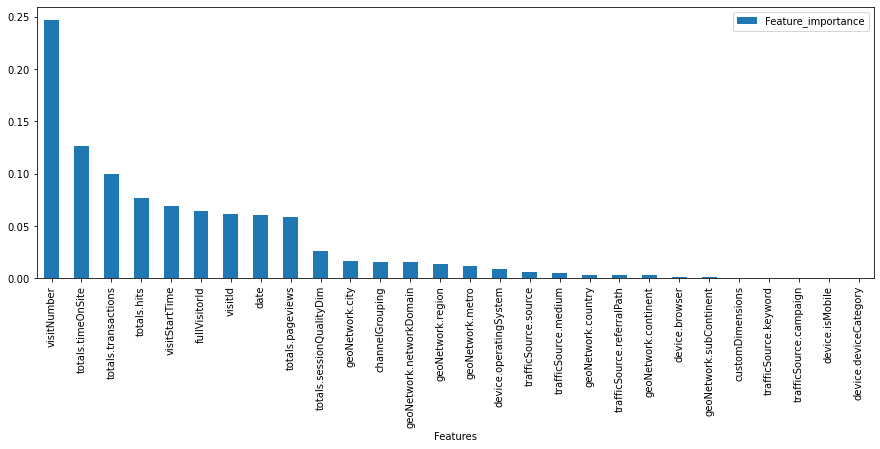

In [26]:
# feature importance
feature_imp = pd.DataFrame({'Features':train_df.drop('totals.transactionRevenue',axis=1).columns.values, 'Feature_importance':random_forest_reg.feature_importances_})
feature_imp.sort_values(by=['Feature_importance'], ascending = False).plot(kind='bar', x='Features', y='Feature_importance', figsize=(15,5));

# New features:- Take log of hits and pageviews

In [12]:
train_df['log_hits'] = np.log1p(train_df['totals.hits'])
train_df['log_pageviews'] = np.log1p(train_df['totals.pageviews'])

test_df['log_hits'] = np.log1p(test_df['totals.hits'])
test_df['log_pageviews'] = np.log1p(test_df['totals.pageviews'])

# save new features

In [13]:
# %%time
with open('../train_new_features.pickle','wb') as f:
    pickle.dump(train_df, f)
with open('../test_new_features.pickle','wb') as f:
    pickle.dump(test_df, f)

In [45]:
# Defining parameters for our RandomForestRegressor model
rf_log = RandomForestRegressor(bootstrap=True, criterion='mse',
       max_features='auto',n_estimators=500, n_jobs=-1,random_state=44, verbose=1)

# Train the regressor model
rf_log.fit(train_input, train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=44, verbose=1)

In [46]:
# don't print console messages while prediction
rf_log.verbose=False
rmse_rf_log = rmse(np.log1p(rf_log.predict(test_input)),np.log1p(test_target))
print(f'RMSE for using log of hits and pageviews: {rmse_rf_log}')

RMSE for using log of hits and pageviews: 1.3157539670153289


In [47]:
# saving rf model with log features
# with open('../rf_log.pickle','wb') as f:
#      pickle.dump(rf_log, f)
with open('../rf_log.pickle','rb') as f:
    rf_log = pickle.load(f)

## Hyperparameter tuning

In [48]:
gridParams = {"n_estimators":[250,500,750,1000],
              "min_samples_split":[2,3,5,7],
              "min_samples_leaf": [1,2,4],
              "max_features": ['auto', 'sqrt', 'log2'],
              'bootstrap': [True, False]
             }

reg = RandomForestRegressor(n_jobs=-1, criterion='mse')

In [49]:
%%time 
# We will use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(reg, gridParams,cv=3,verbose=10)


# Run the Randomsearch cv on the train dataset to fine tune hyperparameters

random_search.fit(train_input, train_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START bootstrap=False, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 1/3; 1/10] END bootstrap=False, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 2.9min
[CV 2/3; 1/10] START bootstrap=False, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 2/3; 1/10] END bootstrap=False, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 2.9min
[CV 3/3; 1/10] START bootstrap=False, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500
[CV 3/3; 1/10] END bootstrap=False, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 2.9min
[CV 1/3; 2/10] START bootstrap=True, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=500
[CV 1/3; 2/10] END bootstrap=True, max_features=log2, min_samples_leaf=4, min_sam

In [78]:
# save random search model
# with open('../random_search.pickle','wb') as f:
#     pickle.dump(random_search, f)
with open('../random_search.pickle','rb') as f:
    random_search = pickle.load(f)

In [51]:
# Print the best parameters found
print(random_search.best_params_)

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}


In [52]:
%%time
best_rf_model = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, 
                                      max_features='sqrt', bootstrap=True, verbose=1,n_jobs=-1,random_state=44)
best_rf_model.fit(train_input, train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min


CPU times: user 25min 9s, sys: 932 ms, total: 25min 10s
Wall time: 3min 11s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


In [59]:
# don't print console messages while prediction
best_rf_model.verbose=False
rmse_best_rf = rmse(np.log1p(best_rf_model.predict(test_input)), np.log1p(test_target))
rmse_best_rf_train = rmse(np.log1p(best_rf_model.predict(train_input)), np.log1p(train_target))
print(f'RMSE after Hyperparameter Tuning: {rmse_best_rf}')
print(f'RMSE after Hyperparameter Tuning TRAIN: {rmse_best_rf_train}')

RMSE after Hyperparameter Tuning: 6.326789972059268
RMSE after Hyperparameter Tuning TRAIN: 2.177458574751302


In [60]:
# saving rf model after hyperparameter tuning
# with open('../best_rf_model.pickle','wb') as f:
#     pickle.dump(best_rf_model, f)
with open('../best_rf_model.pickle','rb') as f:
    best_rf_model = pickle.load(f)

# SGD-Regressor

In [61]:
gridParams = {"penalty":['l1','l2','elasticnet'],
              "alpha":[0.1,0.01,0.001,0.0001],
              "epsilon": [0.01,0.1,0.5],
              "learning_rate": ['optimal', 'invscaling', 'adaptive'],
              'shuffle': [True, False]
             }

svr = SGDRegressor(loss='epsilon_insensitive')

In [28]:
train_df.describe()

,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,totals.timeOnSite,totals.transactions,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,log_hits,log_pageviews
count,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,...,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06
mean,4.489546e+00,2.643055e+00,7.365042e+05,4.556797e-02,1.498352e+09,2.335170e+00,1.498352e+09,6.584821e+01,1.352323e+01,3.141459e-01,...,6.513215e-03,4.526039e-04,1.355906e+06,4.576642e+00,1.300455e+02,3.445101e+00,3.069752e+03,3.138705e+03,6.703695e-03,7.286859e-03
std,1.730938e+00,1.649023e+00,1.880678e+02,3.117793e-02,1.624937e+07,9.354034e+00,1.624937e+07,1.929871e+01,9.394467e+00,4.641749e-01,...,1.863886e-02,4.618545e-03,4.522808e+07,3.120666e+00,1.409307e+02,2.544593e+00,6.440315e+02,1.191365e+03,1.670585e-02,1.224882e-02
min,0.000000e+00,0.000000e+00,7.361770e+05,0.000000e+00,1.470035e+09,1.000000e+00,1.470035e+09,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,1.000000e+00,7.363230e+05,1.608481e-02,1.482738e+09,1.000000e+00,1.482738e+09,5.500000e+01,7.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,3.207000e+03,3.125000e+03,0.000000e+00,1.998003e-03
50%,4.000000e+00,3.000000e+00,7.365210e+05,4.438355e-02,1.499832e+09,1.000000e+00,1.499832e+09,5.500000e+01,7.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.170000e+02,5.000000e+00,3.207000e+03,3.757000e+03,0.000000e+00,1.998003e-03
75%,6.000000e+00,4.000000e+00,7.366680e+05,7.274507e-02,1.512513e+09,1.000000e+00,1.512513e+09,6.400000e+01,2.200000e+01,1.000000e+00,...,3.996424e-03,0.000000e+00,0.000000e+00,4.000000e+00,1.170000e+02,6.000000e+00,3.207000e+03,3.757000e+03,5.994024e-03,7.968170e-03
max,7.000000e+00,5.000000e+00,7.368140e+05,1.000000e+00,1.525158e+09,4.570000e+02,1.525158e+09,1.600000e+02,2.500000e+01,1.000000e+00,...,9.999999e-01,1.000000e+00,2.312950e+10,4.100000e+01,3.870000e+02,6.000000e+00,4.997000e+03,3.757000e+03,6.931472e-01,6.931472e-01


In [62]:
%%time 
# We will use RandomizedSearchCV for hyperparameter tuning
random_search_svr = RandomizedSearchCV(svr, gridParams,cv=3,verbose=5, n_jobs=-1)


# Run the Randomsearch cv on the train dataset to fine-tune hyperparameters
random_search_svr.fit(train_input, train_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 11.8 s, sys: 982 ms, total: 12.7 s
Wall time: 27min 50s


In [63]:
random_search_svr.best_params_ #didn't normalised target

{'shuffle': False,
 'penalty': 'l2',
 'learning_rate': 'adaptive',
 'epsilon': 0.1,
 'alpha': 0.01}

In [179]:
%%time
svr_best = SGDRegressor(loss='epsilon_insensitive', shuffle=False, penalty='l2', learning_rate='adaptive',
                       epsilon=0.1, alpha=0.01, random_state=44)
svr_best.fit(train_input, train_target)

CPU times: user 12.8 s, sys: 1.29 s, total: 14.1 s
Wall time: 14.1 s


In [180]:
svr_best.predict(test_input)

array([5.64686352e+11, 5.64670159e+11, 5.64673454e+11, ...,
       5.68476639e+11, 5.68472356e+11, 5.68472554e+11])

In [181]:
print(svr_best.score(train_input, train_target))
print(svr_best.score(test_input, test_target))

-150282047.6375622
-92256723.52603503


In [182]:
rmse_best_svr = rmse(np.dt_bestlog1p(svr_best.predict(test_input)), np.log1p(test_target))
rmse_best_svr_train = rmse(np.log1p(svr_bestdt_best.predict(train_input)), np.log1p(train_target))
print(f'RMSE after Hyperparameter Tuning: {rmse_best_svr}')
print(f'RMSE after Hyperparameter Tuning TRAIN: {rmse_best_svr_train}')

RMSE after Hyperparameter Tuning: 26.926790559890904
RMSE after Hyperparameter Tuning TRAIN: 26.911805412306844


In [183]:
with open('../svr_best.pickle','wb') as f:
    pickle.dump(svr_best, f)

# Decision Tree

In [76]:
%%time
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(criterion='mse', random_state=44)
dt.fit(train_input, train_target)

CPU times: user 3.23 s, sys: 84.6 ms, total: 3.32 s
Wall time: 3.32 s


In [84]:
dt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 44,
 'splitter': 'best'}

In [85]:
# # don't print console messages while prediction
# rf_log.verbose=False
rmse_dt_log = rmse(np.log1p(dt.predict(test_input)),np.log1p(test_target))
print(f'RMSE for using log of hits and pageviews: {rmse_dt_log}')
rmse_dt_log_train = rmse(np.log1p(dt.predict(train_input)),np.log1p(train_target))
print(f'RMSE for using log of hits and pageviews: {rmse_dt_log_train}')

RMSE for using log of hits and pageviews: 1.3179528931743423
RMSE for using log of hits and pageviews: 5.840326023966267e-08


## parmeter tuning

In [89]:
np.random.randint(1,9)

3

In [103]:
gridParams={
    "max_depth":[None,3,5],
    "max_features":['auto','sqrt','log2'],#np.random.randint(1,30),
    "min_samples_leaf":[1,10,100,1000],#np.random.randint(1,10),
    "splitter":['best','random']
}

In [104]:
%%time
dt_reg = DecisionTreeRegressor(criterion='mse')

# We will use RandomizedSearchCV for hyperparameter tuning
random_search_dt = RandomizedSearchCV(dt_reg, gridParams,cv=5,verbose=5, n_jobs=-1)


# Run the Randomsearch cv on the train dataset to fine-tune hyperparameters
random_search_dt.fit(train_input, train_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 3.32 s, sys: 765 ms, total: 4.08 s
Wall time: 29.2 s


In [107]:
random_search_dt.best_params_

{'splitter': 'best',
 'min_samples_leaf': 1000,
 'max_features': 'auto',
 'max_depth': 3}

In [108]:
dt_best = DecisionTreeRegressor(criterion='mse', splitter='best', min_samples_leaf=1000, max_features='auto',
                               max_depth=3)
dt_best.fit(train_input, train_target)

DecisionTreeRegressor(max_depth=3, max_features='auto', min_samples_leaf=1000)

In [178]:
with open('../dt_best.pickle','wb') as f:
    pickle.dump(dt_best, f)

In [109]:
# # don't print console messages while prediction
# rf_log.verbose=False
rmse_dt_log = rmse(np.log1p(dt_best.predict(test_input)),np.log1p(test_target))
print(f'RMSE for using log of hits and pageviews: {rmse_dt_log}')
rmse_dt_log_train = rmse(np.log1p(dt_best.predict(train_input)),np.log1p(train_target))
print(f'RMSE for using log of hits and pageviews: {rmse_dt_log_train}')

RMSE for using log of hits and pageviews: 1.2093187016940776
RMSE for using log of hits and pageviews: 0.17445874118840898


# LGB

In [158]:
import lightgbm as lgb

In [160]:
%%time
lgb_regressor = lgb.LGBMRegressor(objective='regression', random_state=44, n_jobs=-1, silent=False)
lgb_regressor.fit(train_input, train_target)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 1708337, number of used features: 30
[LightGBM] [Info] Start training from score 1355906.345748
CPU times: user 32.9 s, sys: 326 ms, total: 33.2 s
Wall time: 5.23 s


In [161]:
rmse(np.log1p(lgb_regressor.predict(test_input)), np.log1p(test_target))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


10.847529469074143

In [172]:
%%time
gridParams = {
    'learning_rate': [0.1,0.01,0.5],
    'n_estimators': [50,100,150,200],
    # gbdt’, traditional Gradient Boosting Decision Tree.
    #‘dart’, Dropouts meet Multiple Additive Regression Trees. 
    #‘goss’, Gradient-based One-Side Sampling.
    'boosting_type' : ['gbdt','dart','goss'], 
    'objective' : ['regression'],
    'reg_alpha' : [0.01,0.1,0.5], #L1 reg
    'reg_lambda' : [0.01,0.1,0.5], #L2 reg
    }

lgb_reg = lgb.LGBMRegressor(silent=False)

# We will use RandomizedSearchCV for hyperparameter tuning
random_search_lgb = RandomizedSearchCV(lgb_reg, gridParams,cv=5,verbose=5, n_jobs=-1)


# Run the Randomsearch cv on the train dataset to fine-tune hyperparameters
random_search_lgb.fit(train_input, train_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 59.3 s, sys: 1.06 s, total: 1min
Wall time: 4min 54s


In [173]:
random_search_lgb.best_params_

{'reg_lambda': 0.1,
 'reg_alpha': 0.5,
 'objective': 'regression',
 'n_estimators': 150,
 'learning_rate': 0.01,
 'boosting_type': 'goss'}

In [174]:
%%time
best_lgb = lgb.LGBMRegressor(objective='regression', reg_alpha=0.5, reg_lambda=0.1,random_state=44,
                                  n_estimators=150, learning_rate=0.01, boosting_type='goss',n_jobs=-1,
                                  silent=False)
best_lgb.fit(train_input, train_target)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 1708337, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 1355906.345748
CPU times: user 1min, sys: 335 ms, total: 1min 1s
Wall time: 8.63 s


In [175]:
# # don't print console messages while prediction
# rf_log.verbose=False
rmse_lgb = rmse(np.log1p(best_lgb.predict(test_input)),np.log1p(test_target))
print(f'RMSE LGB test data: {rmse_adaboost}')
rmse_lgb_train = rmse(np.log1p(best_lgb.predict(train_input)),np.log1p(train_target))
print(f'RMSE LGB train data: {rmse_adaboost_train}')

RMSE LGB test data: 13.065136696637664
RMSE LGB train data: 13.044395717756865


In [177]:
with open('../best_lgb.pickle','wb') as f:
    pickle.dump(best_lgb, f)

In [124]:
val_input = train_input[int(train_input.shape[0]*.7):]
val_target = train_target[int(train_input.shape[0]*.7):]

In [126]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model
pred_test, model, pred_val = run_lgb(train_input, train_target, val_input, val_target, test_input)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.35876e+07
[200]	valid_0's rmse: 3.23129e+07
[300]	valid_0's rmse: 3.12468e+07
[400]	valid_0's rmse: 3.05204e+07
[500]	valid_0's rmse: 2.98178e+07
[600]	valid_0's rmse: 2.91191e+07
[700]	valid_0's rmse: 2.85242e+07
[800]	valid_0's rmse: 2.80204e+07
[900]	valid_0's rmse: 2.75589e+07
[1000]	valid_0's rmse: 2.70967e+07
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.70967e+07


# Adaboost

In [149]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

base_tree = DecisionTreeRegressor(criterion='mse')
base_svm = SVR()
base_linear = LinearRegression()

gridParams = {
    #"base_estimator":[base_tree],#, base_svm, base_linear],
    "n_estimators":[100,150,200],
    "loss":["linear", "square", "exponential"],
    "learning_rate": [0.1,1,0.5,1.5]
}

adaboost = AdaBoostRegressor()

In [150]:
%%time 
# We will use RandomizedSearchCV for hyperparameter tuning
random_search_adaboost = RandomizedSearchCV(adaboost, gridParams,cv=3,verbose=1, n_jobs=-1)


# Run the Randomsearch cv on the train dataset to fine-tune hyperparameters
random_search_adaboost.fit(train_input, train_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 14min 36s, sys: 9.34 s, total: 14min 46s
Wall time: 1h 8min 18s


In [151]:
random_search_adaboost.best_params_

{'n_estimators': 100, 'loss': 'square', 'learning_rate': 0.1}

In [156]:
%%time
adaboost.fit(train_input, train_target)

CPU times: user 5min 33s, sys: 8.59 s, total: 5min 41s
Wall time: 5min 41s


AdaBoostRegressor()

In [157]:
# # don't print console messages while prediction
# rf_log.verbose=False
rmse_adaboost = rmse(np.log1p(adaboost.predict(test_input)),np.log1p(test_target))
print(f'RMSE Adaboost test data: {rmse_adaboost}')
rmse_adaboost_train = rmse(np.log1p(adaboost.predict(train_input)),np.log1p(train_target))
print(f'RMSE Adaboost train data: {rmse_adaboost_train}')

RMSE Adaboost test data: 16.804068320169215
RMSE Adaboost train data: 15.976314929026671


In [152]:
%%time
best_adaboost = AdaBoostRegressor(n_estimators=100, loss='square', learning_rate=0.1)
best_adaboost.fit(train_input, train_target)

CPU times: user 14min 29s, sys: 8.96 s, total: 14min 38s
Wall time: 14min 38s


In [18]:
# with open('../best_adaboost.pickle','wb') as f:
#     pickle.dump(best_adaboost, f)
with open('../best_adaboost.pickle','rb') as f:
    best_adaboost = pickle.load(f)

In [23]:
# # don't print console messages while prediction
# rf_log.verbose=False
rmse_adaboost = rmse(np.log1p(best_adaboost.predict(test_input)),np.log1p(test_target))
print(f'RMSE Adaboost test data: {rmse_adaboost}')
rmse_adaboost_train = rmse(np.log1p(best_adaboost.predict(train_input)),np.log1p(train_target))
print(f'RMSE Adaboost train data: {rmse_adaboost_train}')

RMSE Adaboost test data: 1.2527137574681133
RMSE Adaboost train data: 0.22441850594310653


# kaggle submission

In [16]:
# read sample submission
sample_submission = pd.read_csv('../sample_submission_v2.csv')
print(sample_submission.shape)
sample_submission.head(2)

(296530, 2)


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.0
1,0000039738481224681,0.0


In [46]:
test_df['fullVisitorId'] = test_df.fullVisitorId.astype('str')

In [47]:
test_df.fullVisitorId.nunique()

294996

In [24]:
adaboost_preds = np.log1p(best_adaboost.predict(test_input))
len(adaboost_preds)

401589

In [17]:
sample_submission.fullVisitorId.nunique()

296530

In [190]:
train_df.fullVisitorId.nunique()

1286027

In [29]:
test_df.shape

(401589, 31)

In [28]:
print(test_df.fullVisitorId.nunique())
test_df.head(2)

294996


,channelGrouping,customDimensions,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,totals.sessionQualityDim,totals.transactions,totals.transactionRevenue,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,log_hits,log_pageviews
0,4,1,736825,7.460955e+18,1526099341,2,1526099341,55,1,1,...,0.01,0.0,0.0,0,4,117,5,8,0.005994,0.005982
1,2,4,736825,4.602524e+17,1526064483,166,1526064483,55,7,0,...,0.01,0.0,0.0,0,4,0,0,9,0.005994,0.005982


401589

In [32]:
test_input.fullVisitorId.nunique()

294996

In [37]:
sub_df.log_predictions.describe()

count    401589.000000
mean          0.298177
std           2.358799
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          22.590818
Name: log_predictions, dtype: float64

In [40]:
sub_df = pd.DataFrame(test_input.fullVisitorId.values)
sub_df["PredictedLogRevenue"] = adaboost_preds
sub_df.columns = ['fullVisitorId', 'PredictedLogRevenue']
print(sub_df.shape)
sub_df.head(2)
# sub_df.to_csv("adaboost_submission.csv", index=False)

(401589, 2)


,fullVisitorId,PredictedLogRevenue
0,7.460955e+18,0.0
1,4.602524e+17,0.0


In [43]:
sub_df = sub_df.groupby('fullVisitorId')['PredictedLogRevenue'].sum().reset_index()
sub_df.head()
print(sub_df.shape)

(294996, 2)


In [44]:
sub_df.to_csv('adaboost_submission.csv', index=False)